# Machine Learning Demonstration

To run this notebook, you need to install python dependencies:

Install tensorflow:

With conda:

```conda install -c conda-forge tensorflow```

With pip:

```pip install tensorflow```

> If you have a GPU in your computer, you can better install the gpu version to speed up some computations by following the instructions in this link: https://www.tensorflow.org/install/

Other dependencies:

With pip:

```pip install numpy==1.14.0
pip install pandas==0.20.3
pip install matplotlib==2.1.1
pip install Keras==2.0.9
pip install scikit_learn==0.19.1```

## Using AI Techniques to Forecast GNSS Disruptions

A Global Navigation Satellite System (GNSS) is a network of satellites providing geospatial positioning with global coverage. Such a network relies upon radio communications between satellites and ground-based receivers, which can be subject to interruptions in the presence of extreme space weather events.

Space weather refers to changes in radiation emitted by the Sun, leading to fluctuations in the Earth’s ionosphere. Changes to the electron density in the ionosphere cause fluctuations in the amplitude and phase of radio signals, known as phase scintillation. Radio signals propagating between GNSS satellites and ground-based receivers are affected by these scintillation events and can become inaccurate or even lost. 

In a society that has become dependent on GNSS services for navigation in everyday life, it is important to know when signal disruptions might occur. Given that space weather events occurring between the Sun and the Earth have a non-linear relationship, physical models have struggled to predict scintillation events. One solution is to use artificial intelligence (AI) technologies to create machine learning (ML) models. 

In this notebook, we examine the use of ML models to predict scintiallation events, using historical GNSS data. Initially, a support vector machine (SVM) was used to recreate the baseline model outlined in McGranaghan et al., 2018. We then implement a neural network model in an attempt to improve upon the baseline results. Both methods used the strength of kdb+/q to deal with time-series data and embedPy to import the necessary python ML libraries.


## Data

Publicly available data was used to develop the ML models discussed below. Different datasets describe the state of the Sun, the ionosphere and the magnetic field of the Earth. Combining these datasets created an overall picture of atmospheric conditions at each timestep, including when scintillation events occured.

The first dataset was collected by the Canadian High Arctic Ionospheric Network (CHAIN) from high-latitude GNSS receivers (login required - http://chain.physics.unb.ca/chain/pages/data_download). 14 CHAIN receiver stations with the most continuous data were used. The latitude and longitude of each PolaRxS station can be found on the CHAIN website  (http://chain.physics.unb.ca/chain/pages/stations/). Recorded features for each receiver include; TEC, differential TEC (current TEC minus TEC recorded 15 seconds previously), the scintillation index, the phase and amplitude scintillation indices and the phase spectral slope.

Solar and geomagnetic features can be found in the second dataset, which is available on the NASA OMNI database (ftp://spdf.gsfc.nasa.gov/pub/data/omni/). Features in the data include solar wind properties (velocity, power, and the Newell and Borovsky constants), magnetic properties (magnetic field strength, IMF and clock angle), and geomagnetic indices (AE and SymH), along with proton fluxes and solar X-ray measurements. Additional indices Kp and F10.7 are available from the NOAA Geostationary Satellite Server (https://satdat.ngdc.noaa.gov/sem/goes/data/full/).

The third dataset was collected by magnetometers at high latitudes in the Canadian Array for Real-time Investigations of Magnetic Activity Network (CARISMA) (http://data.carisma.ca/FGM/1Hz/).


## Preprocessing

Initial preprocessing can be found in the script preprocessing.q. CHAIN data was corrected for non-scintillation irregularities by only including data from satellites where lock-times with the receivers were greater than 200 seconds, and where elevation was above 30 degrees. The phase and amplitude scintillation indices were projected to the vertical, to correct for geomagnetic effects in measurements recorded at different elevations. Latitude and longitude for each station were also added to the data. Historical values recorded 15 and 30 minutes previously were included in the Solar dataset for each input parameter from the OMNI dataset.

For all three datasets, datetime columns were added. Solar data which was recorded in 5 and 60 minutes intervals. Given that CHAIN and magnetometer data were recorded at 1 minute intervals for each CHAIN receiver station, station columns were added to each and solar data was forward filled at the missing timesteps to allow consistency across the data.

Once preprocessed, data was persisted as a date-partitioned kdb+ database. Scripts were written to create configuration tables (configSVM.q and configNN.q), specifying the features and scaling required for each model.

## 1 SVM Baseline Model

A SVM will be used to recreate the baseline model outlined in McGranaghan et al., 2018. CHAIN and solar datasets from 2015 are used, with measurements recorded at 1 minute intervals, where CHAIN data is recorded for each of the 14 receiver stations.

### 1.1 Data

In [1]:
\c 12 100
\l /SpaceWeather/test
\l ../sw1/utils.q
\l ../sw1/graphics.q
\l ../sw1/configSVM.q

predTime:1 3 6 9 12 24
predCol:`sigPhiVer1hr`sigPhiVer3hr`sigPhiVer6hr`sigPhiVer9hr`sigPhiVer12hr`sigPhiVer24hr

-1"SVM Configuration Table:\n";
show configSVM
-1"\nShape of chain is ",sv[" x "]string(count chain;count cols chain);
-1"Shape of solar is ",sv[" x "]string(count solar;count cols solar);
-1"Shape of goes is ",sv[" x "]string(count goes;count cols goes);

SVM Configuration Table:

table colname   feature scaler
------------------------------
chain dt        0       ::    
chain doy       0       ::    
chain cs        0       ::    
chain tec       1       ::    
chain dtec      1       ::    
chain SI        1       ::    
chain specSlope 1       ::    
..

Shape of chain is 3706506 x 12
Shape of solar is 1576801 x 31
Shape of goes is 520757 x 3


In [2]:
/utils
splitIdx:{[x;y]k:neg[n]?n:count y;p:floor x*n;(p _ k;p#k)}
metrics:{$[1=count key x;
            [$[first key x;[`tp set first value x;`tn`fn`fp set'3#0];[`tn set first value x;`tp`fn`fp set'3#0]]];
            [`tn`fn set'first x;`fp`tp set'last x]];
         100*precdict`tn`fn`fp`tp!(tn;fn;fp;tp)}
getTabDate:{[dt;cfg;t]?[t;enlist(=;`date;dt);0b;{x!x}exec colname from cfg where table=t]}
predVal:{[t;hr]t lj 2!?[t;();0b;(`dt`cs,`$"sigPhiVer",string[hr],"hr")!((-;`dt;"u"$60*hr);`cs;`sigPhiVer)]}

In [3]:
sdateSVM:2015.01.01
edateSVM:2015.08.31

1"Selecting data from ",sv[" - ";string sdateSVM,edateSVM],"\n\n";

getAllDateSVM:{[dt]
  r:tabs!getTabDate[dt;configSVM;]each tabs:`chain`solar`goes;
  t:select from(r[`chain]lj`dt xkey update solarMatch:1b from r`solar)where solarMatch; 
  select from(t lj`dt xkey update goesMatch:1b from r`goes)where goesMatch}
show completeSVM:raze getAllDateSVM peach sdateSVM+til 1+edateSVM-sdateSVM

-1"\nShape of merged chain and solar tables is ",sv[" x "]string shape completeSVM;

Selecting data from 2015.01.01 - 2015.08.31

dt                            doy cs  tec      dtec   SI    specSlope s4         sigPhiVer  Bz   ..
-------------------------------------------------------------------------------------------------..
2015.01.01D00:00:00.000000000 1   arv 16.31073 0.285  0.014 1.77      0.04130524 0.03474961 1.05 ..
2015.01.01D00:00:00.000000000 1   chu 20.58558 0.003  0.009 1.89      0.03389442 0.03238033 1.05 ..
2015.01.01D00:00:00.000000000 1   cor 17.63518 0.072  0.013 2.06      0.04001991 0.0569824  1.05 ..
2015.01.01D00:00:00.000000000 1   edm 26.65708 -0.046 0.01  1.86      0.0443945  0.03070174 1.05 ..
2015.01.01D00:00:00.000000000 1   fsi 27.10333 -0.011 0.008 1.77      0.02914058 0.02512171 1.05 ..
2015.01.01D00:00:00.000000000 1   fsm 21.78102 -0.033 0.009 1.83      0.02766845 0.02570405 1.05 ..
2015.01.01D00:00:00.000000000 1   gil 24.6702  -0.009 0.012 2.06      0.03305384 0.07465466 1.05 ..
..

Shape of merged chain and solar tables is 3659237 x

### 1.2 Extra Features
Scintillation events are subject to seasonal variations. To account for this, the sine and cosine time of day and day of year were added to the data. For the baseline, only the cosine day of year is added.

$$\begin{eqnarray}
cosdoy = cos\Big(\frac{2 \pi doy}{D_{tot}}\Big), && sindoy = sin\Big(\frac{2 \pi doy}{D_{tot}}\Big)
\end{eqnarray}$$
$$ $$
$$\begin{eqnarray}
costime = cos\Big(\frac{2 \pi dt}{T_{tot}}\Big), && sintime = sin\Big(\frac{2 \pi dt}{T_{tot}}\Big)
\end{eqnarray}$$

where $doy$ is the day of year, $D_{tot}$ is the number of days in the year (365 for this model), $dt$ is the time in minutes and $T_{tot}$ is the number of minutes in a day. The feature names must be added to the configuration table, with relevant scaling, to allow for scaling at a later stage.

In [4]:
completeSVM:update cosdoy:cos 2*pi*doy%365 from completeSVM
configSVM,:(`completeSVM;`cosdoy;1b;log1p)

### 1.3 Target Data
The occurrence of scintillation events are shown by sudden irregularities in a number of features, specifically the phase scintillation index, $\sigma_\phi$, which is projected to the vertical throughout this work (sigPhiVer). As the baseline looks at predicting scintillation 1 hour ahead, the value of $\sigma_\phi$ 1 hour ahead of the current timestep (sigPhiVer_1hr) was used as target data for the models.

Ideally, data would have been recorded for each CHAIN station, at every minute throughout 2015. However, receivers can experience faults which lead to timesteps with no recorded data. To examine where these gaps occur in the data, a list containing timesteps for 2015, with minute granularity, can be merged to the full data table, with target values plotted for each timestep.

In [5]:
/import python libraries using embedPy
array: .p.import[`numpy]`:array
plt:   .p.import[`matplotlib]`:pyplot
svc:   .p.import[`sklearn.svm]`:SVC

Phase scintillation index per CHAIN station from 2015.01.01 - 2015.08.31



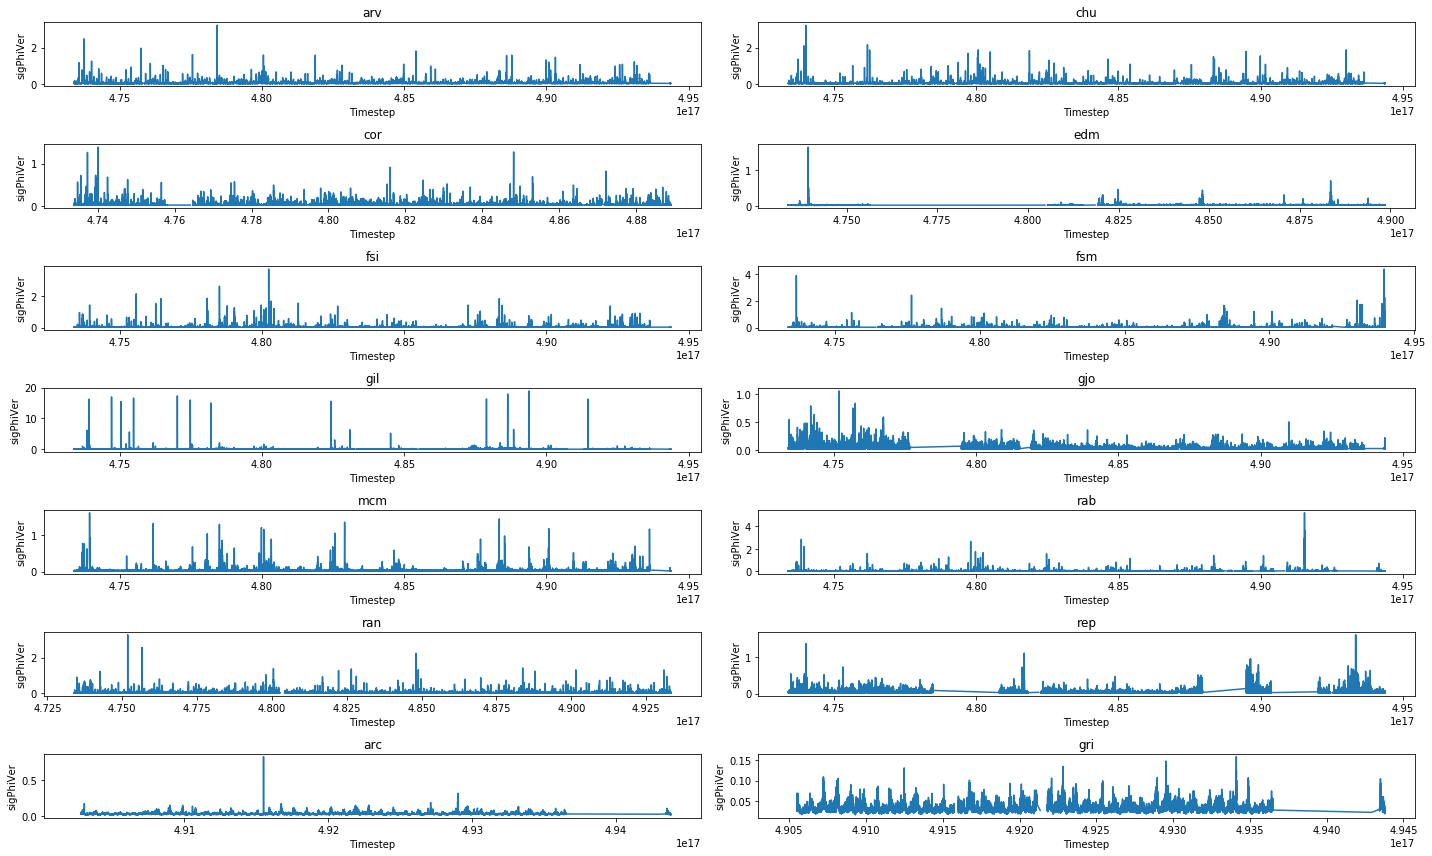

In [6]:
1"Phase scintillation index per CHAIN station from ",(sv[" - "]string(sdateSVM;edateSVM)),"\n\n";

plt[`:figure]`figsize pykw 20 12;
{ stn:(distinct completeSVM`cs)x;
  tab:exec dt,cs,sigPhiVer from completeSVM where cs=stn;
  plt[`:subplot]. 7 2,x+1;
  plt[`:title]string stn:(distinct completeSVM`cs)x;
  plt[`:xlabel]"Timestep";
  plt[`:ylabel]"sigPhiVer";
  plt[`:plot][tab`dt;tab`sigPhiVer];
 }each til 14;

plt[`:tight_layout][];
plt[`:show][];

### 1.4 Feature Engineering
To account for gaps in the data, rows containing nulls will be dropped. As ML models are sensitive to inputs with large ranges, some features in the input data were log(1+x) scaled (as defined in the SVM configuration table). All features will be standard scaled at a later stage, before feeding the data to the SVM classifier.

In [7]:
completeSVM@:where not any flip null completeSVM
completeSVM:flip(exec first scaler by colname from configSVM)@'flip completeSVM

-1"Scintillation events:\n";
show distSVM:update pcnt:round[;.01]100*num%sum num from select num:count i by scintillation from([]scintillation:.1<completeSVM`sigPhiVer)
-1"\n",(string first exec pcnt from select pcnt from distSVM where scintillation)," percent of the target values represent scintillation occurring.";

Scintillation events:

scintillation| num   pcnt 
-------------| -----------
0            | 59651 97.77
1            | 1362  2.23 

2.23 percent of the target values represent scintillation occurring.


In [8]:
/add target columns for each prediction time
completeSVM:predVal/[completeSVM;predTime]

In [9]:
/separate data
show svmData:(`ALL,stn)!enlist[completeSVM],{select from completeSVM where cs=x}each stn:distinct completeSVM`cs

ALL| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
arv| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
chu| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
cor| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
edm| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
fsi| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
fsm| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
gil| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
gjo| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
..


### 1.5 Metrics
As only 3% of the data represented scintillation occuring, it would have been easy to create a model which produced high accuracy. A naive model which predicted that scintillation never occured would still have been correct 97% of the time. Additional metrics, including the Total Skill Statistic (TSS) will be used to determine how well the models perform.
$$\begin{equation}TSS=\frac{TP}{TP+FN}-\frac{FP}{FP+TN}\end{equation}$$

where $TP$, $TN$, $FP$ and $FN$ are true positives, true negatives, false positives and false negatives respectively.

### 1.6 Running model for ARV station
Below, a total of **40,000** random data points will be selected. X data is selected according to the SVM configuration table and y data is sigmaPhiVer_1hr to allow 1 hour prediction. Standard scaling will be applied to x data to remove the mean and scale each feature to unit variance. Meanwhile, target data will be left unscaled and assigned a binary value.

When scintillation events take place, $\sigma_\phi$ will have a value which is greater than 0.1 radians. Therefore, target data will be assigned a value of 1 if greater than 0.1 radians (positive class) and 0 with a value below (negative class).

Initially, two sets of shuffled indices are produced, covering the full set of indices in the data. These indices will then be used to split x and y data into split into training (80%) and testing (20%) sets.

In [10]:
\S 10

sampleSVM:t neg[c]?c:count t:svmData`arv
xSVM:flip stdscaler each flip(exec colname from configSVM where feature)#sampleSVM
ySVM:.1<sampleSVM first predCol
show svmInputs:`xtrn`ytrn`xtst`ytst!raze(xSVM;ySVM)@\:/:splitIdx[.2;ySVM]

xtrn| +`tec`dtec`SI`specSlope`s4`sigPhiVer`Bz`Bz_15`Bz_30`By`By_15`By_30`V`V_15`V_30`P`P_15`P_30`..
ytrn| 0000000000000000000000000000000000000000000000010000000010000000000000000000000000000000000..
xtst| +`tec`dtec`SI`specSlope`s4`sigPhiVer`Bz`Bz_15`Bz_30`By`By_15`By_30`V`V_15`V_30`P`P_15`P_30`..
ytst| 0000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000..


In [11]:
start:.z.T;
svmModel:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
svmModel[`:fit][array[value flip svmInputs`xtrn]`:T;svmInputs`ytrn];
-1"Training SVM model for a single station took ",string .z.T-start;

Training SVM model for a single station took 00:00:05.782


Now that the model has been trained, it will can be used to make predictions using test data. These predictions will be compared with y test values using a confusion matrix.

In [12]:
svmPred:svmModel[`:predict][array[value flip svmInputs`xtst]`:T]`
-1"Confusion matrix results for SVM model trained/tested on ARC:\n";
show svmCM:cfm[svmInputs`ytst;svmPred]
-1"\nPerformance metric results:\n";
show(`model`cs`pred!(`SVM;`arc;first predCol)),metrics svmCM

Confusion matrix results for SVM model trained/tested on ARC:

0| 940 11
1| 150 6 

Performance metric results:

model      | `SVM
cs         | `arc
pred       | `sigPhiVer1hr
accuracy   | 85.45619
errorRate  | 14.54381
precision  | 3.846154
recall     | 35.29412
specificity| 86.23853
TSS        | 0.2153265


### 1.7 Running model for all stations and prediction times

In [13]:
\S 20

trainPredSVM:{[stn;col]

  sample:t neg[c]?c:count t:svmData stn;
  xdata:flip stdscaler each flip(exec colname from configSVM where feature)#sample;
  ydata:.1<sample col;
  r:`xtrn`ytrn`xtst`ytst!raze(xdata;ydata)@\:/:splitIdx[.2;ydata];

  start:.z.T;
  model:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
  if[(::)~ .[model[`:fit];(array[value flip r`xtrn]`:T;r`ytrn);{[e] -2"Error: ",e;}];:()];
  -1"Training SVM model for a single station took ",string .z.T-start;

  pred:model[`:predict][array[value flip r`xtst]`:T]`; 
  CM:cfm[r`ytst;pred];
  (`model`cs`pred!(`SVM;stn;col)),metrics CM

  }

The baseline model uses combined data from all stations. Therefore, the model will first be trained and tested using combined data, and then run using data from individual stations.

In [78]:
start:.z.T;
svmRes:trainPredSVM . '(`ALL,stn)cross predCol
-1"Total SVM training time: ",string .z.T-start;

Training SVM model for a single station took 00:26:12.941
Training SVM model for a single station took 00:33:55.127
Training SVM model for a single station took 00:38:41.533
Training SVM model for a single station took 00:39:46.496
Training SVM model for a single station took 00:39:17.776
Training SVM model for a single station took 00:39:06.146
Training SVM model for a single station took 00:00:06.171
Training SVM model for a single station took 00:00:07.365
Training SVM model for a single station took 00:00:07.715
Training SVM model for a single station took 00:00:07.768
Training SVM model for a single station took 00:00:08.322
Training SVM model for a single station took 00:00:08.192
Training SVM model for a single station took 00:00:04.655
Training SVM model for a single station took 00:00:05.694
Training SVM model for a single station took 00:00:06.771
Training SVM model for a single station took 00:00:06.972
Training SVM model for a single station took 00:00:07.493
Training SVM m

Error: call: Class label 1 not present.


Training SVM model for a single station took 00:00:00.021


Error: call: Class label 1 not present.


Total SVM training time: 03:48:13.280


In [104]:
show svmRes:svmRes except svmRes[87 89]

model cs  pred          accuracy errorRate precision recall   specificity TSS         
--------------------------------------------------------------------------------------
SVM   ALL sigPhiVer1hr  82.84707 17.15293  10.54482  80.80808 82.89794    0.6370602   
SVM   ALL sigPhiVer3hr  74.53696 25.46304  5.882353  78.92562 74.44816    0.5337378   
SVM   ALL sigPhiVer6hr  71.41452 28.58548  4.87601   70.28112 71.43813    0.4171926   
SVM   ALL sigPhiVer9hr  67.75938 32.24062  4.817194  70.65217 67.69244    0.3834461   
SVM   ALL sigPhiVer12hr 69.6771  30.3229   4.914586  69.51673 69.68072    0.3919745   
SVM   ALL sigPhiVer24hr 72.50451 27.49549  4.947614  65.63707 72.65344    0.382905    
SVM   arv sigPhiVer1hr  86.72087 13.27913  10.96774  65.38462 87.23404    0.5261866   
SVM   arv sigPhiVer3hr  86.5402  13.4598   8.176101  81.25    86.61778    0.6786778   
SVM   arv sigPhiVer6hr  82.65583 17.34417  4.568528  69.23077 82.81536    0.5204613   
SVM   arv sigPhiVer9hr  82.47516 17.52484  

### 1.8 MCM model
Train the SVM model using data **32,000** random points from the Fort McMurray (mcm) station and test using **8,000** points from each of the remaining stations.

In [18]:
\S 30

sampleMCM:m neg[c]?c:count m:svmData`mcm;
xtrnMCM:flip stdscaler each flip(exec colname from configSVM where feature)#sampleMCM;
ytrnMCM:.1<sampleMCM first predCol;

start:.z.T;
mcmModel:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
mcmModel[`:fit][array[value flip xtrnMCM]`:T;ytrnMCM];
-1"Training SVM model for MCM station took ",string .z.T-start;

Training SVM model for MCM station took 00:00:05.994


In [20]:
\S 40

predMCM:{[stn;col]

  sampleTst:r neg[c]?c:count r:svmData stn;
  xtst:flip stdscaler each flip(exec colname from configSVM where feature)#sampleTst;
  ytst:.1<sampleTst col;

  start:.z.T;
  pred:mcmModel[`:predict][array[value flip xtst]`:T]`;
  -1"Testing SVM model for a single station took ",string .z.T-start;

  CM:cfm[ytst;pred];
  (`model`cs`pred!(`MCM;stn;col)),metrics CM

  }

In [21]:
start:.z.T;
mcmRes:predMCM . 'except[stn;`mcm]cross first predCol
-1"Total MCM model training time: ",string .z.T-start;

Testing SVM model for a single station took 00:00:00.833
Testing SVM model for a single station took 00:00:00.793
Testing SVM model for a single station took 00:00:00.564
Testing SVM model for a single station took 00:00:00.433
Testing SVM model for a single station took 00:00:00.781
Testing SVM model for a single station took 00:00:00.772
Testing SVM model for a single station took 00:00:00.765
Testing SVM model for a single station took 00:00:00.703
Testing SVM model for a single station took 00:00:00.704
Testing SVM model for a single station took 00:00:00.767
Testing SVM model for a single station took 00:00:00.574
Testing SVM model for a single station took 00:00:00.135
Testing SVM model for a single station took 00:00:00.121
Total MCM model training time: 00:00:08.324


In [22]:
\c 100 100
mcmRes

model cs  pred         accuracy errorRate precision recall   specificity TSS       
-----------------------------------------------------------------------------------
MCM   arv sigPhiVer1hr 87.05075 12.94925  6.013986  48.86364 87.66746    0.365311  
MCM   chu sigPhiVer1hr 88.14909 11.85091  6.784661  66.66667 88.42067    0.5508733 
MCM   cor sigPhiVer1hr 86.71329 13.28671  7.462687  52.63158 87.37271    0.4000429 
MCM   edm sigPhiVer1hr 91.7     8.3       6.439394  89.47368 91.71419    0.8118787 
MCM   fsi sigPhiVer1hr 88.26836 11.73164  7.352941  74.62687 88.43612    0.6306299 
MCM   fsm sigPhiVer1hr 88.03306 11.96694  6.828528  66.17647 88.31589    0.5449236 
MCM   gil sigPhiVer1hr 85.6529  14.3471   19.71154  31.53846 89.9053     0.2144376 
MCM   gjo sigPhiVer1hr 86.74894 13.25106  12.95732  50.29586 88.03938    0.3833524 
MCM   rab sigPhiVer1hr 88.79518 11.20482  7.993197  73.4375  88.99512    0.6243262 
MCM   ran sigPhiVer1hr 86.69996 13.30004  6.98324   48.54369 87.44107    0.3

## 2 Neural Network (NN) Model
To improve performance metrics, a neural network model will be used. Going forward, only components selected in the feature selection process (featureselection.ipynb) will be used (found in the NN configuration table).

As results showed that scintillation events are localized, localized features will be added to the dataset to account for the position of each station. These included the magnetometer dataset along with additional features mentioned below.
### 2.1 Data

In [23]:
\c 12 110
\l ../sw1/configNN.q

In [24]:
sdateNN:2015.01.01
edateNN:2015.08.31

1"Selecting data from ",sv[" - ";string sdateNN,edateNN],"\n\n";

getAllDateNN:{[dt]
  r:tabs!getTabDate[dt;configNN;]each tabs:`chain`solar`goes`mag;
  t1:select from(r[`chain]lj`dt xkey update solarMatch:1b from r`solar)where solarMatch; 
  t2:select from(t1 lj`dt xkey update goesMatch:1b from r`goes)where goesMatch;
  select from(t2 lj`dt`cs xkey update magMatch:1b from r`mag)where magMatch}
show completeNN:raze getAllDateNN peach sdateNN+til 1+edateNN-sdateNN

-1"\nShape of merged chain and solar tables is ",sv[" x "]string shape completeNN;

Selecting data from 2015.01.01 - 2015.08.31

dt                            doy cs  tec      dtec   SI    specSlope s4         sigPhiVer  lat      long  ..
-----------------------------------------------------------------------------------------------------------..
2015.01.01D00:00:00.000000000 1   chu 20.58558 0.003  0.009 1.89      0.03389442 0.03238033 58.75928 -94.08..
2015.01.01D00:00:00.000000000 1   mcm 26.4495  -0.009 0.007 1.82      0.02682024 0.02189605 56.64954 -111.2..
2015.01.01D00:01:00.000000000 1   chu 23.5022  0      0.008 1.86      0.03101697 0.02482456 58.75928 -94.08..
2015.01.01D00:01:00.000000000 1   mcm 28.21376 -0.042 0.006 1.79      0.02449711 0.02454222 56.64954 -111.2..
2015.01.01D00:02:00.000000000 1   chu 22.22837 -0.006 0.009 1.94      0.03004769 0.02475049 58.75928 -94.08..
2015.01.01D00:02:00.000000000 1   mcm 27.80834 -0.043 0.006 1.86      0.02343506 0.02284805 56.64954 -111.2..
2015.01.01D00:03:00.000000000 1   chu 23.701   -0.014 0.01  1.87      0.031

### 2.2 Extra Features
As mentioned above, extra columns sindoy, cosdoy, sintime and cosdoy were added to account for variations in the data. In this model, 365.25 is used for $D_{tot}$ to account for the extra day present in a leap year. The names of the new features are added to the NN configuration table to account for scaling at a later stage. 

In [25]:
a:{2*pi*x%365.25}
b:{(2*pi*`int$`minute$x)%1440}
completeNN:update sindoy:sin a[doy],cosdoy:cos a[doy],sintime:sin b[dt],costime:cos b[dt]from completeNN
{configNN,:(x;y;1b;z)}'[4#`completeNN;`sindoy`cosdoy`sintime`costime;(log1p;log1p;(::);(::))];

When a scintillation event occurs, geomagnetic features such as xcomp, ycomp, zcomp and dTEC_15s will fluctuate drastically, shown in the plot below. 

In [26]:
newval:{abs(x-avg x)}
completeNN:update newx:newval x,newy:newval y,newz:newval z,newdtec:newval dtec from completeNN
{configNN,:(x;y;1b;z)}'[4#`completeNN;`newx`newy`newz`newdtec;4#(::)];

In [27]:
/add target columns for each prediction time
completeNN:predVal/[completeNN;predTime]

In [77]:
/separate data
show dataNN:(`ALL,nnStn)!(enlist[completeNN],{?[completeNN;enlist(in;`cs;enlist x);0b;()]}each nnStn:distinct completeNN`cs)

ALL| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_..
chu| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_..
mcm| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_..
fsi| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_..


### 2.3 Feature Engineering - running model for MCM
Following the same method as the SVM model, nulls will be dropped, with features selected and standard scaled. For the NN model, features will be exponentially weighted to give more recent data the highest importance. Target data will also be log scaled to prevent negative predictions for $\sigma_\phi$, which is always positive. A train-test split of 80%-20% will again be used.

In [30]:
\S 50

sampleNN@:where not any flip null sampleNN:dataNN`mcm
scaledNN:flip(exec first scaler by colname from configNN)@'flip sampleNN
xNN:flip stdscaler each flip(exec colname from configNN where feature)#scaledNN
xNN:flip(reverse ema[.1]reverse@)each flip xNN
yNN:log sampleNN[first predCol]
show nnInputs:`xtrn`ytrn`xtst`ytst!raze(xNN;yNN)@\:/:splitIdx[.2;yNN]

xtrn| +`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_30`newell`newell_15..
ytrn| -3.334894 -3.643222 -3.674656 -3.806156 -3.950073 -2.644393 -3.795388 -3.589648 -3.793101 -3.749087 -..
xtst| +`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_30`newell`newell_15..
ytst| -3.881431 -3.754943 -3.860069 -3.60631 -3.766346 -3.553889 -3.759877 -3.54098 -3.69487 -3.808001 -3.7..


To overcome the small fraction of data representing scintillation events, oversampling is used on the training set. A random sample taken from the positive class and re-added to the training dataset, giving a final training set with 50% positive samples.

In [31]:
\S 60

positiveIdx:where yscint:.1<exp nnInputs`ytrn
pos:`x`y!{x[y]}[;positiveIdx]each(nnInputs`xtrn;nnInputs`ytrn)
sampleIdx:(nadd:(-) . sum each yscint=/:(0 1))?count pos`x
sample:`x`y!{x[y]}[;sampleIdx]each(pos`x;pos`y)
oversampled:`x`y!(nnInputs`xtrn;nnInputs`ytrn),'(sample`x;sample`y)

-1"Scintillation events before oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:yscint)
-1"\nScintillation events after oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:.1<exp oversampled`y)

Scintillation events before oversampling:

ybinary| num  pcnt 
-------| ----------
0      | 4103 98.25
1      | 73   1.75 

Scintillation events after oversampling:

ybinary| num  pcnt
-------| ---------
0      | 4103 50  
1      | 4103 50  


### 2.4 Model
We can use embedPy to import the python libraries necessary for creating the NN.

In [33]:
sequential:    .p.import[`keras.models]`:Sequential
dense:         .p.import[`keras.layers]`:Dense
normalization: .p.import[`keras.layers]`:BatchNormalization
pylist:        .p.import[`builtins]`:list

The model has 1 input layer, 4 hidden layers and 1 output layer. A normal distribution is used as the initializer for the kernel to set the weights in each layer of the model.

The input and hidden layers output width of 256 nodes, along with an Exponential Linear Unit (ELU) activation function, which gives the best model performance. ELU was specifically chosen as it converged the loss function to zero better than other activation functions, such as a Rectified Linear Unit (RELU).

The output layer has 1 node and a linear activation function to allow a single value for $\sigma_\phi$ to be returned for each timestep.

In [35]:
nnModel:sequential[];
nnModel[`:add]dense[256;`input_dim pykw 37;`kernel_initializer pykw`normal;`activation pykw`elu];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[1;`activation pykw`linear];
nnModel[`:compile][`loss pykw`mean_squared_error;`optimizer pykw`adam;`metrics pykw pylist `mse`mae]; 

We can now train the model for 50 epochs, using batch sizes of 512 each time. The model performs validation using 20% of the training data.

In [36]:
epochs:50
batchsz:512

In [37]:
start:.z.T;
nnModel[`:fit][array[value flip oversampled`x]`:T;oversampled`y;`batch_size pykw batchsz;`verbose pykw 3;`epochs pykw epochs;`validation_split pykw .2];
-1"Training sequential model for ",string[epochs]," epochs took ",string .z.T-start;

Train on 6564 samples, validate on 1642 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Training sequential model for 50 epochs took 00:00:24.252


Once trained, the model can be used to make predictions 1 hour ahead. Outputs will be assigned binary values, using the 0.1 radians threshold, and can then be compared to the y test values selected previously.

In [38]:
nnPred:raze(nnModel[`:predict]array[value flip nnInputs`xtst]`:T)`
value`predVal`binpredVal!(exp nnPred;.1<exp nnPred)

0.01537679 0.01890498 0.01658679 0.01951059 0.01700157 0.02682969 0.02003282 0.02616643 0.01989861 0.017255..
0          0          0          0          0          0          0          0          0          0       ..



Confusion matrix for neural network model:



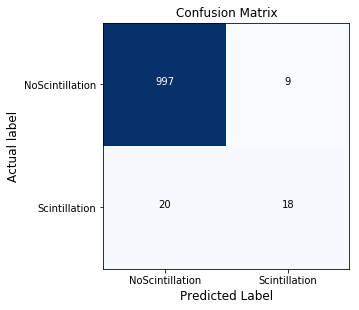

In [39]:
-1"\nConfusion matrix for neural network model:\n";
nnCM:cfm[.1<exp nnInputs`ytst;.1<exp nnPred]
displayCM[value nnCM;`NoScintillation`Scintillation;"Confusion Matrix";()]

In [40]:
-1"Performance metric results:\n";
show(`model`cs`pred!(`NN;`mcm;first predCol)),metrics nnCM

Performance metric results:

model      | `NN
cs         | `mcm
pred       | `sigPhiVer1hr
accuracy   | 97.22222
errorRate  | 2.777778
precision  | 47.36842
recall     | 66.66667
specificity| 98.03343
TSS        | 0.647001


### 2.5 Running model for all stations and prediction times

In [41]:
\S 70

trainPredNN:{[stn;col]

  t@:where not any flip null t:dataNN[stn];
  scl:flip(exec first scaler by colname from configNN)@'flip t;
  xdata:flip stdscaler each flip(exec colname from configNN where feature)#scl;
  xdata:flip(reverse ema[.1]reverse@)each flip xdata;
  ydata:log t[col];
  r:`xtrn`ytrn`xtst`ytst!raze(xdata;ydata)@\:/:splitIdx[.2;ydata];

  positiveIdx:where yscint:.1<exp r`ytrn;
  pos:`x`y!{x[y]}[;positiveIdx]each(r`xtrn;r`ytrn);
  sampleIdx:(nadd:(-) . sum each yscint=/:(0 1))?count pos`x;
  sample:`x`y!{x[y]}[;sampleIdx]each(pos`x;pos`y);
  oversampled:`x`y!(r`xtrn;r`ytrn),'(sample`x;sample`y);

  start:.z.T;
  nnModel[`:fit][array[value flip oversampled`x]`:T;oversampled`y;`batch_size pykw batchsz;`verbose pykw 0;`epochs pykw epochs;`validation_split pykw .2];
  -1"Training sequential model for ",string[epochs]," epochs took ",string .z.T-start;

  pred:raze(nnModel[`:predict]array[value flip r`xtst]`:T)`;
  CM:cfm[.1<exp r`ytst;.1<exp pred];
  (`model`cs`pred!(`NN;stn;col)),metrics CM

  }

In [42]:
start:.z.T;
nnRes:trainPredNN . '(`ALL,distinct completeNN`cs)cross predCol
-1"Total NN training time: ",string .z.T-start;

Training sequential model for 50 epochs took 00:00:47.404
Training sequential model for 50 epochs took 00:00:53.346
Training sequential model for 50 epochs took 00:00:47.611
Training sequential model for 50 epochs took 00:00:47.685
Training sequential model for 50 epochs took 00:00:47.324
Training sequential model for 50 epochs took 00:00:46.752
Training sequential model for 50 epochs took 00:00:20.965
Training sequential model for 50 epochs took 00:00:20.634
Training sequential model for 50 epochs took 00:00:20.200
Training sequential model for 50 epochs took 00:00:25.971
Training sequential model for 50 epochs took 00:00:19.490
Training sequential model for 50 epochs took 00:00:19.390
Training sequential model for 50 epochs took 00:00:20.363
Training sequential model for 50 epochs took 00:00:20.830
Training sequential model for 50 epochs took 00:00:20.776
Training sequential model for 50 epochs took 00:00:21.206
Training sequential model for 50 epochs took 00:00:21.124
Training seque

In [43]:
\c 100 100
nnRes

model cs  pred          accuracy errorRate precision recall   specificity TSS         
--------------------------------------------------------------------------------------
NN    ALL sigPhiVer1hr  97.7418  2.258202  20        21.875   98.7905     0.206655    
NN    ALL sigPhiVer3hr  98.04005 1.959949  22.22222  30.76923 98.79362    0.2956285   
NN    ALL sigPhiVer6hr  97.69919 2.30081   16.66667  14.70588 98.91915    0.1362503   
NN    ALL sigPhiVer9hr  98.12527 1.874734  32.14286  26.47059 99.17856    0.2564914   
NN    ALL sigPhiVer12hr 97.78441 2.215594  18.51852  14.28571 99.04844    0.1333416   
NN    ALL sigPhiVer24hr 97.95484 2.045164  40        23.25581 99.34896    0.2260477   
NN    chu sigPhiVer1hr  98.12623 1.873767  9.090909  10       99.00398    0.09003984  
NN    chu sigPhiVer3hr  98.02761 1.972387  27.27273  20       99.1992     0.191992    
NN    chu sigPhiVer6hr  98.42209 1.577909  33.33333  6.666667 99.7998     0.06466466  
NN    chu sigPhiVer9hr  98.12623 1.873767  

### Comparison of results

In [117]:
\c 50 100
svm124:select from svmRes where pred in `sigPhiVer1hr`sigPhiVer24hr
nn124:select from nnRes where pred in `sigPhiVer1hr`sigPhiVer24hr
`cs`pred xasc select from(svm124,nn124)where cs in(`ALL,distinct completeNN`cs)

model cs  pred          accuracy errorRate precision recall   specificity TSS         
--------------------------------------------------------------------------------------
SVM   ALL sigPhiVer1hr  82.84707 17.15293  10.54482  80.80808 82.89794    0.6370602   
NN    ALL sigPhiVer1hr  97.7418  2.258202  20        21.875   98.7905     0.206655    
SVM   ALL sigPhiVer24hr 72.50451 27.49549  4.947614  65.63707 72.65344    0.382905    
NN    ALL sigPhiVer24hr 97.95484 2.045164  40        23.25581 99.34896    0.2260477   
SVM   chu sigPhiVer1hr  89.68326 10.31674  6.19469   46.66667 90.27523    0.369419    
NN    chu sigPhiVer1hr  98.12623 1.873767  9.090909  10       99.00398    0.09003984  
SVM   chu sigPhiVer24hr 92.85068 7.149321  2.816901  16.66667 93.6871     0.1035377   
NN    chu sigPhiVer24hr 98.32347 1.676529  0         0        99.40179    -0.005982054
SVM   fsi sigPhiVer1hr  89.75521 10.24479  4.347826  62.5     89.95434    0.5245434   
NN    fsi sigPhiVer1hr  97.91667 2.083333  

In [118]:
/
resplot:{[d1;d2;stn]

  plt[`:subplots][1;2;`figsize pykw 20 4];

  plt[`:subplot]121;
  plt[`:scatter][key d1;value[d1]`TSS];
  plt[`:scatter][first key[res`comb];(first value d1)`TSS;`color pykw`black];
  plt[`:grid]1b;
  plt[`:ylim]0 1;
  plt[`:xlabel]"Chain Station";
  plt[`:ylabel]"Total Skill Score";
  plt[`:title]"Individual SVM Results";

  plt[`:subplot]122;
  plt[`:scatter][key d2;value[d2]`TSS;`color pykw `darkorange];
  plt[`:scatter][stn;d2[stn]`TSS;`color pykw`black];
  plt[`:grid]1b;
  plt[`:ylim]0 1;
  plt[`:xlabel]"Chain Station";
  plt[`:ylabel]"Total Skill Score (TSS)";
  plt[`:title]"Fort McMurray SVM Results";

  plt[`:show][];

 }